In [1]:
%matplotlib widget

import numpy as np
import math
import tensorflow as tf
import tensorflow_probability as tfp

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from jacques import kcqe

In [2]:
# Data generation adapted from https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
# Fix random state for reproducibility
np.random.seed(19680801)

def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

n = 500
x0 = randrange(n, -2. * np.pi, 2. * np.pi)
x1 = randrange(n, -2. * np.pi, 2. * np.pi)
y = 10. * np.cos(x0) + 0.5 * x1**2 + np.random.normal(loc=0., scale=5., size=n)

In [3]:
x = np.concatenate([x0[:, np.newaxis], x1[:, np.newaxis]], axis=1)
grid_size = 120
x_test = np.concatenate(
    [np.tile(np.linspace(-2. * np.pi, 2. * np.pi, num = grid_size), grid_size)[:, np.newaxis],
        np.repeat(np.linspace(-2. * np.pi, 2. * np.pi, num = grid_size), grid_size)[:, np.newaxis]],
    axis=1
)

In [4]:
# x_train_val
x = np.reshape(x, (1, 500, 2))
# y_train_val
y = np.reshape(y, (1, 500))

x_test = np.reshape(x_test, (1, 14400, 2))

x = tf.constant(x)
y = tf.constant(y)
x_test = tf.constant(x_test)
    
block_size = 100
num_blocks = math.floor(y.shape[1]/block_size)

In [5]:
kcqe_obj = kcqe.KCQE(p=2)
generator = kcqe_obj.generator(x, y, batch_size = 1, block_size = block_size)

In [6]:
x_val, x_train, y_val, y_train = next(generator)
print(x_val.shape)
print(y_val.shape)
print(x_train.shape)
print(y_train.shape)

(1, 100, 2)
(1, 100)
(1, 200, 2)
(1, 200)


In [7]:
# plug in generator instead of raw data to get away from calculating 7-day avg
# initialize parameters at some bad values; otherwise, convergence is instantaneous
param_vec = kcqe_obj.fit(xval_batch_gen = generator,
    num_blocks = num_blocks, 
    tau=tf.constant(np.array([0.1, 0.5, 0.9])),
    optim_method="adam", 
    num_epochs=10, 
    learning_rate=0.1,
    init_param_vec=tf.constant(np.array([3.0, 3.0, 1.0])),
    verbose = True)

epoch idx = 0
batch idx = 0
loss idx = 1
param estimates vec = 
[2.90000253 2.90000186 1.09993935]
loss = 
2.5736411690197607
grads = 
[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.12474027,  0.16984648, -0.00521053])>]
epoch idx = 0
batch idx = 1
loss idx = 1loss idx = 1
param estimates vec = 
[2.80772329 2.86643261 1.19380327]
loss = 
2.3820556880008183
grads = 
[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.35893307, -0.0700197 , -0.01312032])>]
epoch idx = 0
batch idx = 2
loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[2.71358656 2.80500246 1.28999254]
loss = 
2.496451193358389
grads = 
[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.23087837,  0.15889905, -0.01516449])>]
epoch idx = 0
batch idx = 3
loss idx = 1loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[2.64518294 2.72828541 1.38783851]
loss = 
1.8671764589484792
grads = 
[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-0.06156491,  0.24678094, -0.01421028])>]
epoch idx

In [8]:
param_vec

<tf.Variable 'param_vec:0' shape=(3,) dtype=float64, numpy=array([ 0.78995876, -0.12620887,  3.87315476])>

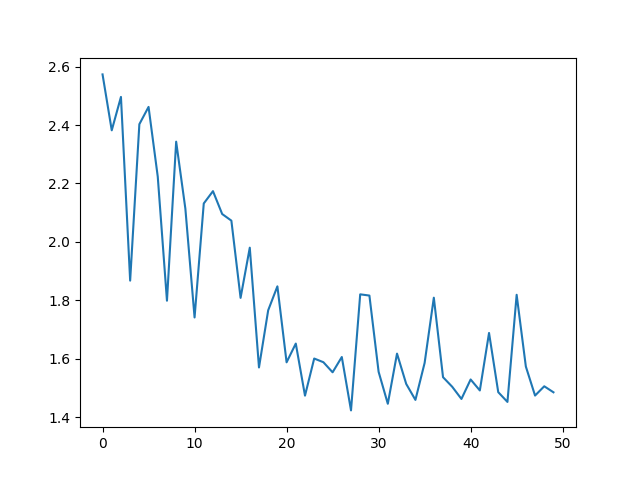

In [9]:
plt.plot(np.arange(len(kcqe_obj.loss_trace)), kcqe_obj.loss_trace)
plt.show()

In [10]:
q_hat = kcqe_obj.predict(param_vec,
                         x_train=x,
                         y_train=y,
                         x_test=x_test,
                         tau=tf.constant(np.array([0.1, 0.5, 0.9])))

/var/folders/0k/lqgy2gfn2dv3d1zpr_y64ygh0000gr/T/ipykernel_7709/9007008.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


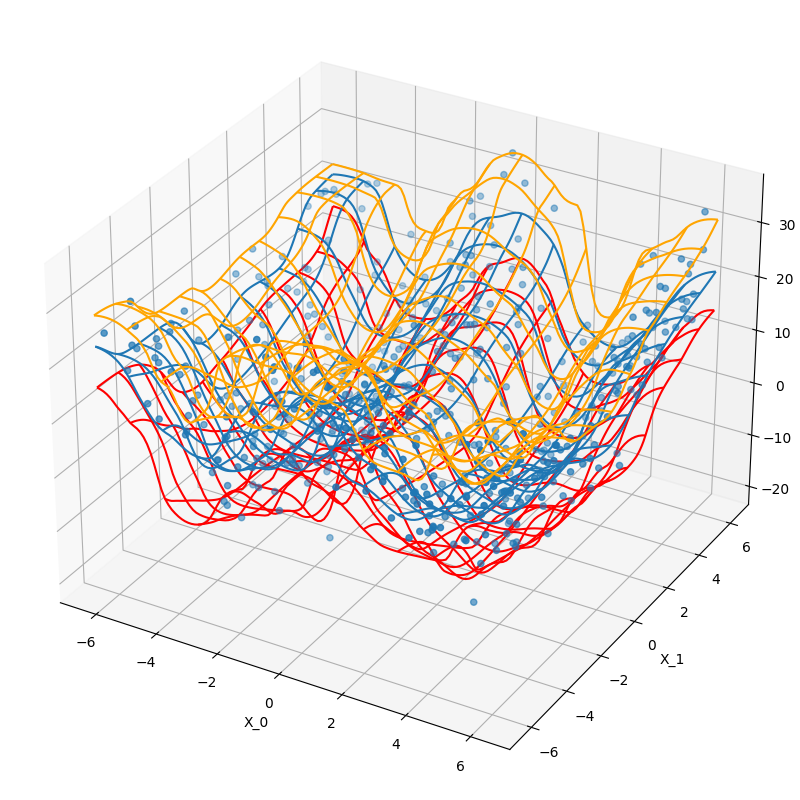

In [11]:
fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

ax.scatter(x0, x1, y)

x0_grid = x_test[..., 0].numpy().reshape((grid_size, grid_size))
x1_grid = x_test[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q10 = q_hat[..., 0].numpy().reshape((grid_size, grid_size))
q_grid_median = q_hat[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q90 = q_hat[..., 2].numpy().reshape((grid_size, grid_size))

ax.plot_wireframe(x0_grid, x1_grid, q_grid_q10, rstride=10, cstride=10, color="red")
ax.plot_wireframe(x0_grid, x1_grid, q_grid_median, rstride=10, cstride=10)
ax.plot_wireframe(x0_grid, x1_grid, q_grid_q90, rstride=10, cstride=10, color="orange")

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

plt.show()